In [2]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from utils import get_targets, get_data_pair, prepare_data

In [3]:
BASE_PATH = 'C:\\Users\\ttanj\\UoB\\WS18\\DBM\\data\data_mmc'
HEIGHT = 100
WIDTH = 100
NUM_CHANNEL = 1
RGB = 0

In [4]:
def get_targets():
    targets = []
    for r in range(1, 4):
        for theta in range(0, 190, 30):
            theta = np.radians(theta)
            targets.append([r * np.cos(theta), r * np.sin(theta)])
    return targets


def get_data_pair():
    data_pair = []
    for dirname in os.listdir(BASE_PATH):
        fnames = os.listdir(os.path.join(BASE_PATH, dirname))
        for j in range(len(fnames) - 1):
            data_pair.append((os.path.join(BASE_PATH, dirname, fnames[j]),
                              os.path.join(BASE_PATH, dirname, fnames[j + 1])))
    return data_pair


def prepare_data(num_channel):
    data_pair = get_data_pair()
    x = np.zeros((len(data_pair), HEIGHT * WIDTH * num_channel))
    y = np.zeros((len(data_pair), HEIGHT * WIDTH * num_channel))
    
    for i, item in zip(range(len(data_pair)), data_pair):
        x[i] = cv2.imread(item[0], RGB).flatten()
        y[i] = cv2.imread(item[1], RGB).flatten()
    
    return x, y

In [5]:
input_img = Input(shape=(HEIGHT, WIDTH, NUM_CHANNEL))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(NUM_CHANNEL, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 8)         0         
__________

In [6]:
x, y = prepare_data(NUM_CHANNEL)

x = x / 255.
y = y / 255.

x = x.reshape((-1, HEIGHT, WIDTH, NUM_CHANNEL))
y = y.reshape((-1, HEIGHT, WIDTH, NUM_CHANNEL))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

autoencoder.fit(x_train, y_train,
                epochs=200,
                batch_size=20,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 453 samples, validate on 51 samples
Epoch 1/200
453/453 [==============================] - 21s 46ms/step - loss: 0.5763 - val_loss: 0.2106
Epoch 2/200
453/453 [==============================] - 21s 47ms/step - loss: 0.2076 - val_loss: 0.1897
Epoch 3/200
453/453 [==============================] - 21s 46ms/step - loss: 0.1802 - val_loss: 0.1743
Epoch 4/200
453/453 [==============================] - 23s 50ms/step - loss: 0.1688 - val_loss: 0.1622
Epoch 5/200
453/453 [==============================] - 21s 45ms/step - loss: 0.1562 - val_loss: 0.1483
Epoch 6/200
453/453 [==============================] - 23s 50ms/step - loss: 0.1406 - val_loss: 0.1321
Epoch 7/200
453/453 [==============================] - 30s 65ms/step - loss: 0.1236 - val_loss: 0.1133
Epoch 8/200
453/453 [==============================] - 34s 75ms/step - loss: 0.1067 - val_loss: 0.0998
Epoch 9/200
453/453 [==============================] - 34s 76ms/step - loss: 0.0941 - val_loss: 0.0889
Epoch 10/200
453/453 [======

In [7]:
decoded_imgs = autoencoder.predict(x_test)

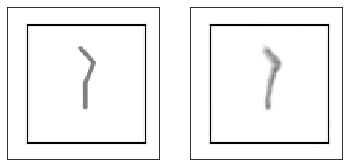

In [11]:
idx = 5

plt.figure()

# display original
ax = plt.subplot(1, 2, 1)
plt.imshow(y_test[idx].reshape(HEIGHT, WIDTH))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# display reconstruction
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[idx].reshape(HEIGHT, WIDTH))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()